# 1. Setup

In [1]:
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.layers import Flatten, Dense
from keras import models
from keras import regularizers
import tensorflow as tf
import math
import os

2023-01-04 21:58:25.936509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# image parameters
input_height = 69
input_width = 69

# augmentation parameters
rescale = True
if rescale:
    rescale_size=1./255
else:
    rescale_size=1
augmentation=False

rotation_range=40
width_shift_range=0.2
height_shift_range=0.1
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'

In [ ]:
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

optimizer='rmsprop'
optimizer_learning_rate=1e-4
epochs=100
batch_size=32
num_classes = 9
regularizer=regularizers.l1_l2(l1=0.001, l2=0.001) # simultaneous l1 and l2, add 0.001*weight_coefficient_value + 0.001 * 1/2*weight^2

if optimizer == 'rmsprop':
    optimizer=optimizers.RMSprop(learning_rate=optimizer_learning_rate)

In [3]:
# customized metrics for multi class classification

import keras.backend as K
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels

def precision(y_true, y_pred):
    """Precision metric.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = [
    precision,
    recall,
    tf.keras.metrics.CategoricalAccuracy(name='acc')
]

2023-01-01 22:40:34.008126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
paths = {
    'TRAIN_PATH' : os.path.join('..','workspace', 'images', 'train'),
    'TEST_PATH' : os.path.join('..','workspace', 'images','test'),
    'EVAL_PATH' : os.path.join('..','workspace', 'images','eval'),
    'IMAGES_PATH': os.path.join('..','workspace','images','all'),
    'LOG_DIR' : os.path.join('..','model', 'log_dir')
 }

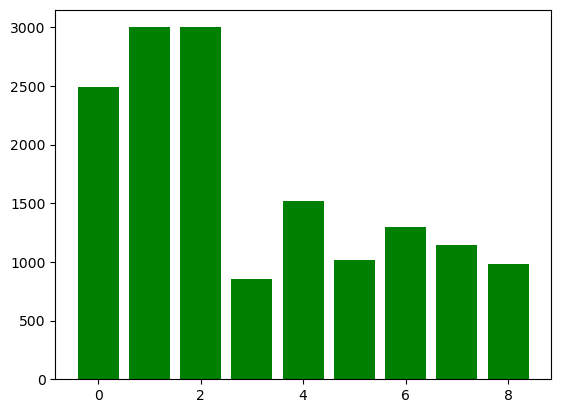

{0: 2488, 1: 3000, 2: 3000, 3: 858, 4: 1523, 5: 1016, 6: 1298, 7: 1146, 8: 981}


In [5]:
# plot training distribution
def plotTrainingDistribution():
    files_per_label = dict()
    for i in range(9):
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
      files_per_label[i] = n_images
    plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
    plt.show()
    print(files_per_label)
    return files_per_label

files_per_label = plotTrainingDistribution()

In [6]:
# class weights computation
tot_images = sum(list(files_per_label.values()))
weights = dict([ (class_label , tot_images/(num_classes * n_images)) for class_label, n_images in files_per_label.items()])
print(weights)

15310
{0: 0.6837263308324402, 1: 0.567037037037037, 2: 0.567037037037037, 3: 1.9826469826469826, 4: 1.1169475450499744, 5: 1.6743219597550307, 6: 1.3105632597158021, 7: 1.4843901493116152, 8: 1.7340582172386454}


In [7]:
# training set image data generator
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

train_dir=paths['TRAIN_PATH']
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 15310 images belonging to 9 classes.


In [8]:
# validation set image data generator
val_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

validation_dir=paths['EVAL_PATH']
validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 3919 images belonging to 9 classes.


# 3. Model creation

In [9]:
from keras.applications import VGG16

# model to be fine-tuned
conv_base = VGG16(weights='imagenet',
                                include_top=False, # exclude fully connected layer
                                input_shape=(input_width, input_height, 3))

In [10]:
def build_model(input_conv_base):
    #build the cnn using the pre-trained cnn
    built_model = models.Sequential()
    built_model.add(input_conv_base)
    # add fully connected layer
    built_model.add(Flatten())
    built_model.add(Dense(64, activation='relu'))
    built_model.add(Dense(9, activation='softmax'))

    return built_model

In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69, 69, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 69, 69, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 69, 69, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 34, 34, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 34, 34, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 34, 34, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 17, 17, 128)       0     

In [12]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name.startswith("block5"): # fine tune layers from block5_*
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = build_model(conv_base)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 14,846,409
Trainable params: 7,211,145
Non-trainable params: 7,635,264
_________________________________________________________________


# 4. Model training

In [14]:
n_images_eval = 0
for i in range(9):
    path = os.path.join(paths['EVAL_PATH'],str(i))
    n_images_eval = n_images_eval + len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

number_training = tot_images
number_eval = n_images_eval

3919


In [15]:
import keras

callbacks_list = [
        # interrupts training when accuracy has stopped improving accuracy on the validation set for at least 3+1=4 epochs
        keras.callbacks.EarlyStopping(
            monitor='acc', # should be part of the metrics specific during compilation
            patience=5,
        ),
        # monitor the model's validation loss and reduce the LR when the validation loss has stopped improving, effective strategy to escape local minima
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # divides LR by 5 when triggered
            patience=3 # called when stopped improving for 3 epochs
        )
]

history = model.fit(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=epochs,
      class_weight=weights,
      validation_data=validation_generator,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)),
      callbacks=callbacks_list)

Epoch 1/100
479/479 [==============================] - 720s 1s/step - loss: 1.1249 - precision: 0.6306 - recall: 0.3767 - acc: 0.5383 - val_loss: 0.9077 - val_precision: 0.7303 - val_recall: 0.4960 - val_acc: 0.6479 - lr: 1.0000e-04
Epoch 2/100
479/479 [==============================] - 698s 1s/step - loss: 0.8486 - precision: 0.7196 - recall: 0.5667 - acc: 0.6598 - val_loss: 0.8925 - val_precision: 0.7261 - val_recall: 0.5366 - val_acc: 0.6458 - lr: 1.0000e-04
Epoch 3/100
479/479 [==============================] - 715s 1s/step - loss: 0.7373 - precision: 0.7544 - recall: 0.6352 - acc: 0.7073 - val_loss: 0.7535 - val_precision: 0.7875 - val_recall: 0.6105 - val_acc: 0.7165 - lr: 1.0000e-04
Epoch 4/100
479/479 [==============================] - 597s 1s/step - loss: 0.6716 - precision: 0.7744 - recall: 0.6711 - acc: 0.7299 - val_loss: 0.6930 - val_precision: 0.7896 - val_recall: 0.6859 - val_acc: 0.7425 - lr: 1.0000e-04
Epoch 5/100
479/479 [==============================] - 677s 1s/step 

# 5. Visualization

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 640x480 with 0 Axes>

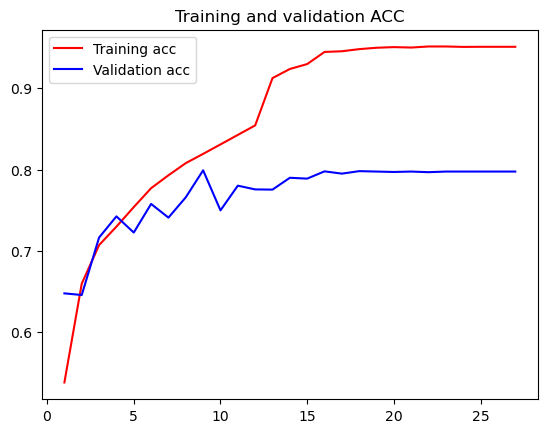

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation ACC')
plt.legend()
plt.figure()

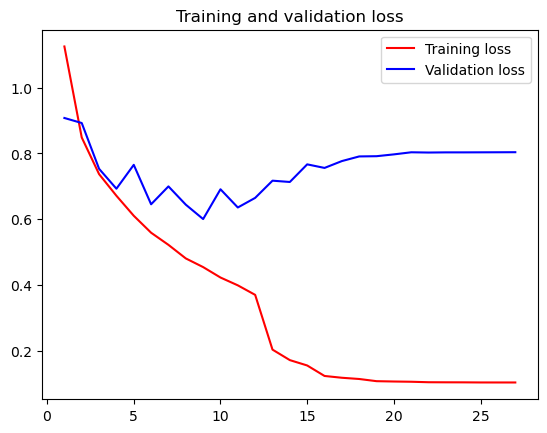

In [18]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

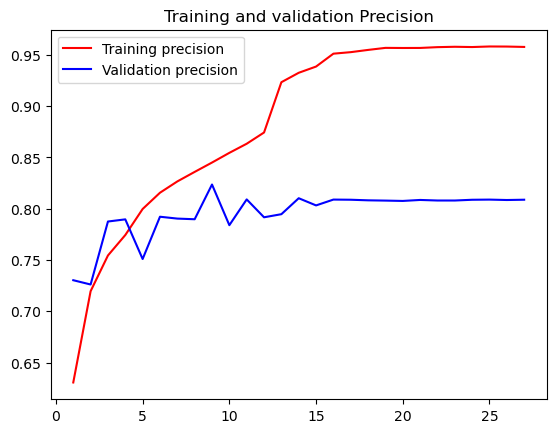

<Figure size 640x480 with 0 Axes>

In [19]:
precision = history.history['precision']
val_precision = history.history['val_precision']
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation Precision')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

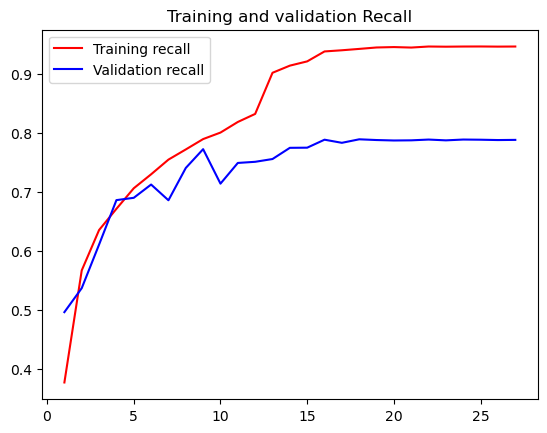

<Figure size 640x480 with 0 Axes>

In [20]:
recall = history.history['recall']
val_recall = history.history['val_recall']
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation Recall')
plt.legend()
plt.figure()

In [ ]:
# smooth curves if they look noisy
# replace each point with an exponential moving average of the previous points
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

In [ ]:
plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# display average, the model may improve even if not reflected

  # 6. Model testing

In [21]:
number_test = 0
for i in range(9):
      path = os.path.join(paths['TEST_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_test += n_images

In [22]:
test_dir=paths['TEST_PATH']
print(test_dir)
test_datagen = ImageDataGenerator(rescale=rescale_size)

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical', classes=None, shuffle=False)

../workspace/images/test
Found 2931 images belonging to 9 classes.


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()
Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0','1','2','3','4','5','6','7','8']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_711/2558299678.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)


Confusion Matrix
[[321  43  57   2   2   1  18  13  14]
 [ 48 847  47   0   0   0   3   0   1]
 [ 77  51 689   0   4   0  12   0   2]
 [  0   0   2  35  10   2   0   0   0]
 [  2   0   4   5 191   4   0   0   1]
 [  0   0   0   2   8  68   0   0   1]
 [ 18   0   2   0   0   0 105  18   0]
 [ 26   0   0   0   0   0  15  79   9]
 [ 13   1   2   0   0   0   0   4  52]]
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       471
           1       0.90      0.90      0.90       946
           2       0.86      0.83      0.84       835
           3       0.80      0.71      0.75        49
           4       0.89      0.92      0.91       207
           5       0.91      0.86      0.88        79
           6       0.69      0.73      0.71       143
           7       0.69      0.61      0.65       129
           8       0.65      0.72      0.68        72

    accuracy                           0.81      2931
   macro avg 

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_711/2081199222.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, verbose = True)


92/92 [==============================] - 71s 767ms/step
Multiclass roc auc score: 0.8743185888748412


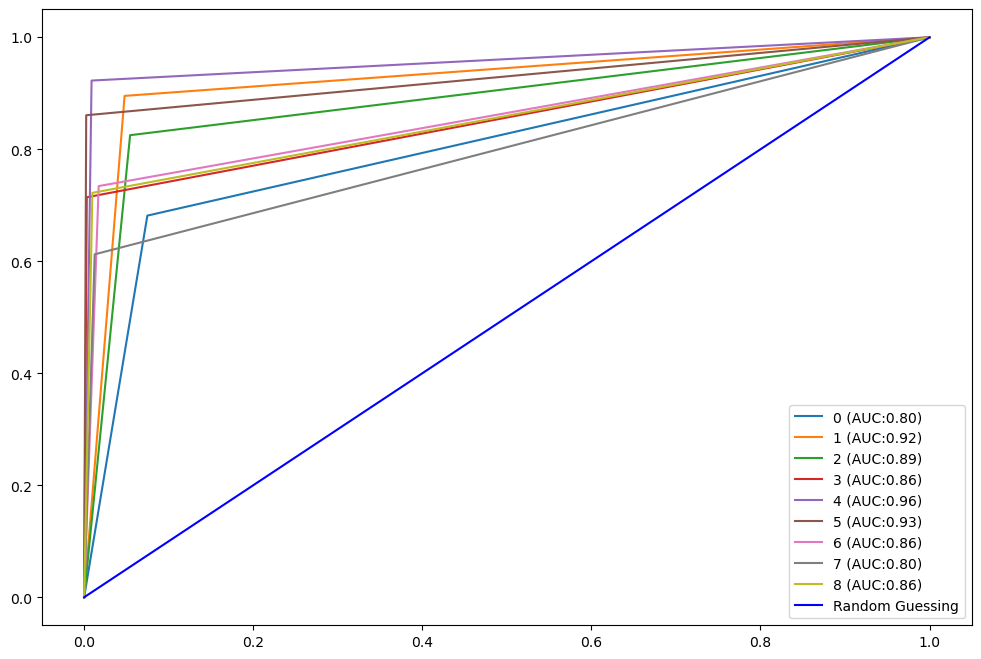

In [24]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)


test_generator.reset()
y_pred = model.predict_generator(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print("Multiclass roc auc score:", multiclass_roc_auc_score(test_generator.classes, y_pred))

# 7. Model exportation

In [28]:
model.save("../models/VGG16_finetuned.h5")

# 8. Plot model as graph of layers

In [26]:
from keras.utils import plot_model

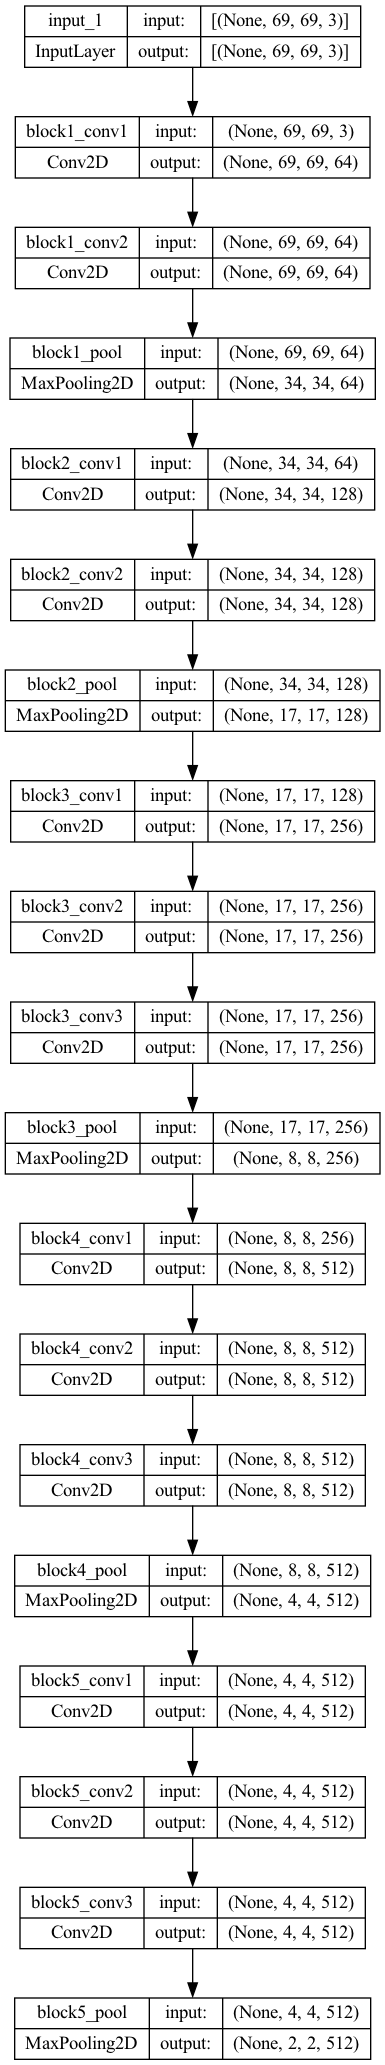

In [29]:
plot_model(conv_base, show_shapes=True, to_file='model_fine_tuned.png')